# **Homework 4: Multinomial Naive Bayes**

Elizabeth Frank IST736 Text Mining Due: August 1, 2025 11:59 pm Submitted: August 1, 2025 11:00pm

---
## **Objective**
---

The goal of this assignment is to evaluate how well a simple probabilistic model can classify restaurant reviews by two different labels. The first task focuses on identifying the sentiment of a review as positive or negative, while the second explores whether a review is truthful or deceptive. Using Multinomial Naive Bayes along with different vectorization strategies to assess how language patterns contribute to model performance. The project also compares model behavior across both tasks to better understand the challenges of detecting tone versus deceptive intent.

---
## **Dataset**
---

The dataset consists of labeled restaurant reviews, each assigned two binary labels. Each entry includes raw review text and two labels, the sentiment of the review, either positive or negative. And the second label indicates whether the review is truthful or deceptive.  

Each record includes:

**review**: raw restaurant review <br>
**Deception**: lie or truth <br>
**Sentiment**: neg or pos

---

### **Import Libraries**

In [105]:
# Data and Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Text Processing
import re
import string
from collections import Counter
import os

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Vectorization
import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Clustering and Projection
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

# Modeling and Evaluation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Utilities
import warnings
warnings.filterwarnings('ignore')
from google.colab import files

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### **Define Functions**


In [106]:
###Visualization Utilities

# Combined boxplot and histogram for numeric feature
def histogram_boxplot(df, feature, figsize=(8, 4), kde=False, bins=None):
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,
        sharex=True,
        gridspec_kw={'height_ratios': (0.25, 0.75)},
        figsize=figsize
    )
    sns.boxplot(data=df, x=feature, ax=ax_box2, showmeans=True, color='violet')
    sns.histplot(data=df, x=feature, kde=kde, ax=ax_hist2, bins=bins or 'auto')
    ax_hist2.axvline(df[feature].mean(), color='green', linestyle='--', label='Mean')
    ax_hist2.axvline(df[feature].median(), color='black', linestyle='-', label='Median')
    ax_hist2.legend()
    plt.tight_layout()
    plt.show()


### Sentiment Utilities (VADER)

# Compound VADER sentiment score and label
def raw_vader_labels(df, text_col='text'):
    sid = SentimentIntensityAnalyzer()
    df_copy = df.copy()
    df_copy['vader_score'] = df_copy[text_col].apply(lambda x: sid.polarity_scores(str(x))['compound'])
    df_copy['vader_sentiment'] = df_copy['vader_score'].apply(
        lambda score: 'pos' if score > 0 else ('neg' if score < 0 else 'neu')
    )
    return df_copy


### Word Cloud & Frequency Analysis

# Generate word cloud from specific column
def overall_wordcloud(df, text_col='text', colormap='PuBuGn', title='Combined Word Cloud'):
    text_data = ' '.join(df[text_col].dropna().astype(str))
    wordcloud = WordCloud(width=1000, height=500, background_color='white', colormap=colormap).generate(text_data)

    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()


# Generate word cloud by grouping
def group_wordclouds(df, text_col='review', group_col='Sentiment', ncols=2, title_suffix=''):
    color_map = {'pos': 'viridis', 'neg': 'plasma', 'truth': 'cividis', 'lie': 'inferno'}
    groups = df[group_col].unique()
    nrows = -(-len(groups) // ncols)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 5 * nrows))
    axes = axes.flatten()

    for i, group in enumerate(groups):
        group_df = df[df[group_col] == group]
        text_data = ' '.join(group_df[text_col].dropna().astype(str))
        cmap = color_map.get(group, 'gray')
        wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=cmap).generate(text_data)
        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].set_title(f"{group.title()} {title_suffix}".strip(), fontsize=14)
        axes[i].axis('off')

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


# Default stopword list
def_stopwords = set(stopwords.words('english'))

# Basic text clean for word clouds
def preprocess_text(text, stopword_list=def_stopwords):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopword_list]
    return tokens


### Model visualization, evaluation, and comparison

# Explore feature importance in modeling
def feature_importance(nb_model, vectorizer, top_n=10):
    feature_probs = nb_model.feature_log_prob_
    prob_diffs = np.abs(feature_probs[0] - feature_probs[1])

    feature_names = vectorizer.get_feature_names_out()
    sorted_idx = np.argsort(prob_diffs)[::-1]

    top_features = feature_names[sorted_idx][:top_n]
    top_diffs = prob_diffs[sorted_idx][:top_n]

    plt.figure(figsize=(10, 6))
    plt.barh(top_features, top_diffs)
    plt.xlabel("Importance (|Log Prob Difference|)")
    plt.title(f"Top {top_n} Discriminative Words (Naive Bayes)")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    return top_features


# Display the accuracy and confusion matrix with labels
def evaluate_model(model, X_test, y_test, y_pred, title='Confusion Matrix'):
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    cnf_matrix = confusion_matrix(y_test, y_pred)
    class_labels = model.classes_

    plt.figure(figsize=(8, 6))
    sns.heatmap(cnf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_labels, yticklabels=class_labels)

    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('Actual Label', fontsize=12)
    plt.title(title, fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()



# Word frequency comparison between groups
def compare_top_words_by_label(df, token_col, label_col, label1, label2, stopword_list, top_n=20, figsize=(18, 10)):
    tokens_1 = [word.lower().strip() for tokens in df[df[label_col] == label1][token_col]
                for word in tokens if word.lower().strip().isalpha() and word.lower().strip() not in stopword_list]

    tokens_2 = [word.lower().strip() for tokens in df[df[label_col] == label2][token_col]
                for word in tokens if word.lower().strip().isalpha() and word.lower().strip() not in stopword_list]

    freq_1 = Counter(tokens_1).most_common(top_n)
    freq_2 = Counter(tokens_2).most_common(top_n)

    words_1, counts_1 = zip(*freq_1)
    words_2, counts_2 = zip(*freq_2)

    all_words = list(set(words_1) | set(words_2))
    palette = sns.color_palette("hls", len(all_words))
    color_map = {word: palette[i] for i, word in enumerate(all_words)}

    colors_1 = [color_map[word] for word in words_1]
    colors_2 = [color_map[word] for word in words_2]

    sns.set(style='whitegrid')
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)

    sns.barplot(x=counts_1, y=words_1, ax=axes[0], palette=colors_1)
    axes[0].set_title(f"Top {top_n} Words in {label1.title()} Reviews")
    axes[0].set_xlabel("Frequency")
    axes[0].set_ylabel("Word")

    sns.barplot(x=counts_2, y=words_2, ax=axes[1], palette=colors_2)
    axes[1].set_title(f"Top {top_n} Words in {label2.title()} Reviews")
    axes[1].set_xlabel("Frequency")
    axes[1].set_ylabel("")

    plt.tight_layout()
    plt.show()

### **Import Data**

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Load the dataset
review_data = pd.read_csv('/content/drive/MyDrive/Syracuse/IST 736 Text Mining/Homework 4/deception_data_converted_final.tsv', sep="\t")

In [179]:
# Create a copy
review_df = review_data.copy()

In [180]:
# Rename and remap columns
review_df.columns = ['lie', 'sentiment', 'review']

# Map label values to relatable text
review_df['Deception'] = review_df['lie'].map({'t': 'truth', 'f': 'lie'})
review_df['Sentiment'] = review_df['sentiment'].map({'p': 'pos', 'n': 'neg'})

review_df = review_df.drop(columns=['lie', 'sentiment'])

review_df.head()

,review,Deception,Sentiment
0,"'Mike\'s Pizza High Point, NY Service was very...",lie,neg
1,'i really like this buffet restaurant in Marsh...,lie,neg
2,"'After I went shopping with some of my friend,...",lie,neg
3,'Olive Oil Garden was very disappointing. I ex...,lie,neg
4,'The Seven Heaven restaurant was never known f...,lie,neg


**Explanation:**


Mapping the original encoded values into more readable formats. The lie and sentiment columns are renamed and remapped to Deception and Sentiment, using the strings 'truth', 'lie', 'pos', and 'neg' for clarity.


###**Data Overview**

In [154]:
# Preview the full song dataframe
review_df.shape

(92, 3)

In [155]:
# Check full posts for data clarity
pd.set_option('display.max_colwidth', None)
review_df[['Deception', 'Sentiment', 'review']].sample(4, random_state=3)

,Deception,Sentiment,review
68,lie,pos,'I ate at this restaurant called Banana Leaf. As I entered the restaurant I really liked the ambiance. I ordered noodle soup and fried rice with spicy black bean curry. The service was pretty fast and the food tasted amazing. There was a lot flavor in the food which I truly enjoyed. Two thumbs up for Banana Leaf and I would totally recommend this restaurant.'
58,lie,pos,"'I went into the restaurant, it decorated comfortably with a soft light and nice pictures, the waitress was kind and stand by my side throughout the whole dining time, asking whether I need something more and kept smiling. '"
90,truth,pos,"'How do I even pick a best experience at Joe\'s Noodle House? It\'s hard to find an authentic Chinese restaurant anywhere in the United States: what we think of as Chinese food is really American food with a few Chinese ingredients. (Chinese food is not usually deep-fried and is virtually never sweet.) A restaurant with a name like \'Joe\'s Noodle House\' doesn\'t sound that promising, but it\'s the best Sichuanese restaurant I\'ve been to in the United States. I\'ve become friends with the waitstaff, all of whom ask after me whenever my father visits the restaurant. It\'s really too bad it\'s in Maryland. I\'d go all the time. I can\'t find any good Chinese food in Syracuse.'"
9,lie,neg,"'Yesterday, I went to a casino-restaurant called \'NoFreeDrinks\'. First, I thought its just a name but later at the blackjack table, when I ordered a attendant to get me a round of Jack and Coke, instead of saying \'Yeah sure\', the attendant said $6. It is preposterous. I have never paid for my drinks at the casino. Clearly, the casino does not understand that the more the people drink, the more they will loose. Someone needs to teach the casino how to do business.'"


In [156]:
# Reset column width to default
pd.reset_option('display.max_colwidth')

**Observation:**

A brief manual scan brings into question the deceiption labeling.  It is confirmed to be accurate to the original dataset so there were no errors in loading and mapping.  

The top review labeled as lie read as fairly genuine, well written, with appropriate details and personal reactions that seem to have a truthful tone. This foreshadows how the deception modeling may face challenges with built in ambiguity, adding to the difficult surface level positivity and narrative structure can easily mimic authenticity or deception.


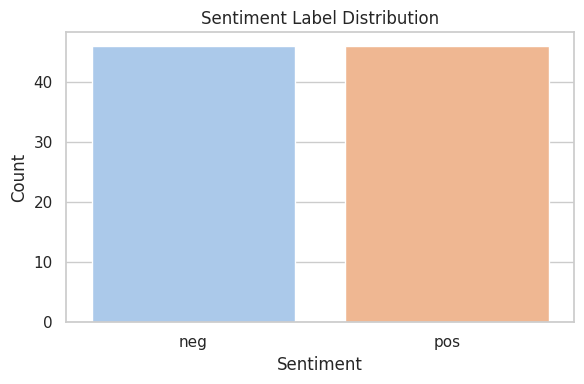

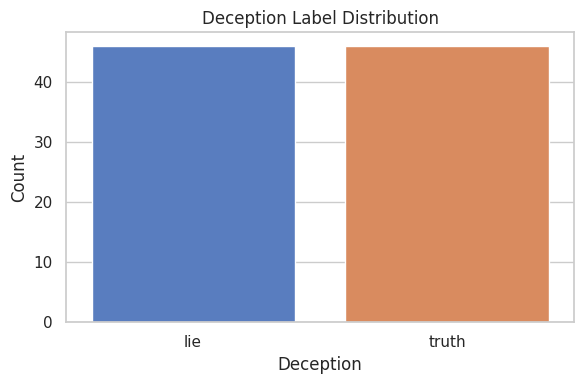

In [157]:
# Labeling distribution
sns.set(style="whitegrid")

# Sentiment distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=review_df, x='Sentiment', palette='pastel')
plt.title('Sentiment Label Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Deception distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=review_df, x='Deception', palette='muted')
plt.title('Deception Label Distribution')
plt.xlabel('Deception')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

**Observation:**

Both sentiment and deception classes are almost perfectly balanced, with an even split between positive and negative sentiment, and between truthful and deceptive reviews. This balance removes class imbalance as a modeling concern and promotes metrics that will be more of actual performance.

In [181]:
# Calculate word count for each text
review_df['word_count'] = review_df['review'].apply(lambda x: len(str(x).split()))

# Generate descriptive statistics for each type
review_df[['word_count']].describe()

,word_count
count,92.000000
mean,75.771739
std,57.528035
min,1.000000
25%,46.000000
50%,67.000000
75%,85.250000
max,474.000000


**Observation:**

The review lengths vary, with a mean around 76 words and a maximum of 474, indicating a few unusually long entries. Most reviews fall within a tighter range, as shown by the 25th to 75th percentile spread between 46 and 85 words, suggesting a relatively consistent review length aside from a few outliers.


### **Exploratory Data Anaylsis**

Positive Review Word Count Distribution


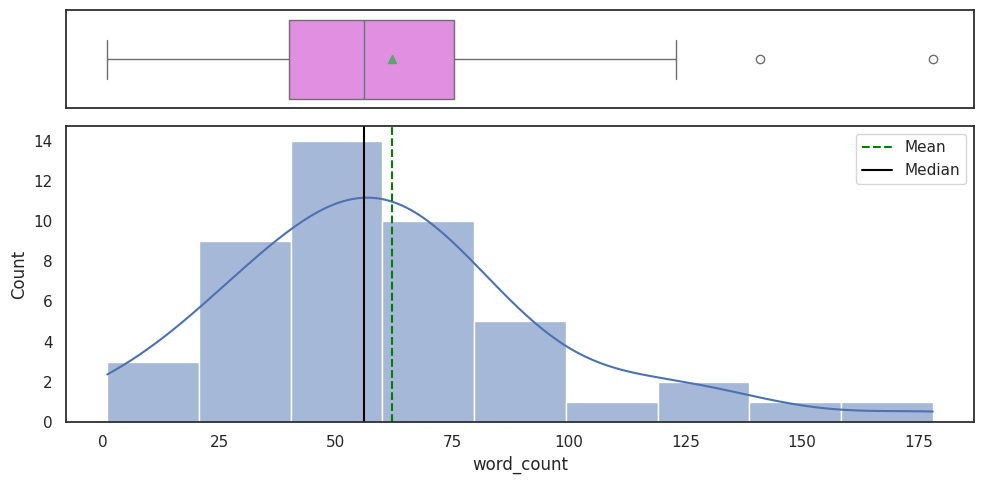

Negative Review Word Count Distribution


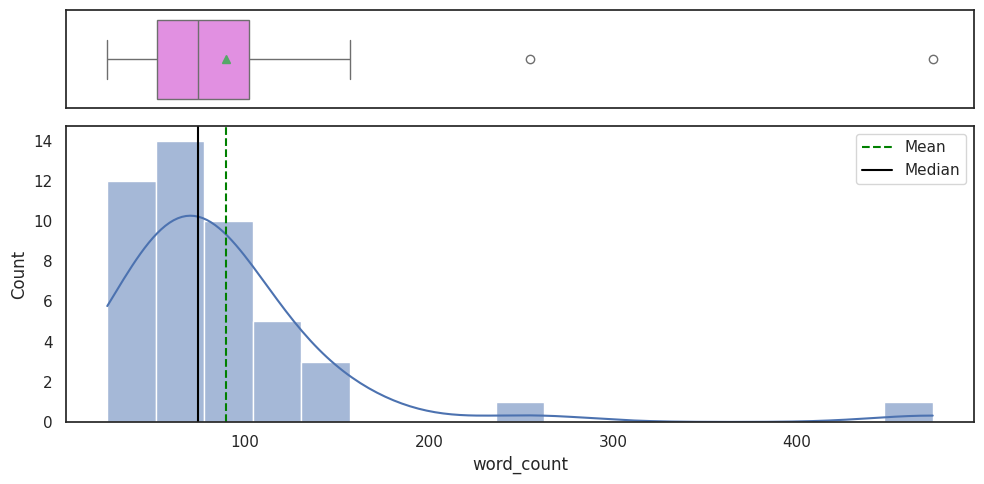

In [161]:
# Distribution of word counts for positive sentiment
print("Positive Review Word Count Distribution")
histogram_boxplot(review_df[review_df['Sentiment'] == 'pos'], 'word_count', figsize=(10, 5), kde=True)

# Visualize the distribution of word counts for negative sentiment
print("Negative Review Word Count Distribution")
histogram_boxplot(review_df[review_df['Sentiment'] == 'neg'], 'word_count', figsize=(10, 5), kde=True)

**Observation:**

Positive reviews tend to be shorter and more tightly distributed around the mean and median, while negative reviews show a wider spread and a heavier tail, with one extending over 400 words. This suggests that negative experiences may prompt more detailed storytelling.

In [43]:
# Find the longest review
long_review = review_df[review_df['word_count'] > 400]

# Display the full review text
pd.set_option('display.max_colwidth', None)
long_review[['Deception', 'Sentiment', 'word_count', 'review']]

,Deception,Sentiment,word_count,review
44,truth,neg,474,"'The food at Lemongrass Restaurant was a mixed bag. The mango burrata salad was the best salad I\'ve had in my life. The main entree, a \'Thai\' dish that we ordered with \'brown tofu*,\' was bland. The prosecco was good. The dessert was adorable (a giant red balloon made of raspberry sorbet!) but not great. However, what really compelled me to write this review was how terrible the service was. My fiance and I were dressed casually, which is not the norm for this restaurant. The waitress essentially took one look at us and began treating us as if we were not going to tip well. Which, incidentally, is virtually never the case: the only time I don\'t tip over 20\% is when the service I\'ve gotten is truly appalling. I\'ve done that maybe three times in my life. This was one of the three. The waitress seemed horrified when we asked to split an entree (I can\'t eat a large amount of food for health reasons), never bothered to bring us a wine menu (we had to ask the sommalier, who, to his credit, seemed pretty appalled!), and when we ordered a single glass of prosecco to share because we thought it\'d be \'more romantic to share a glass\', she first pressured us (\'just one glass??\') and then ignored us (she brought out two champagne flutes and poured half of the bottle into each glass. We poured them into the same glass and put the second flute conspicuously across the table. The sommalier took it away for us. One of our biggest pet peeves is being ignored due to perceived social class. As my fiance likes to say, \'Bill Gates has a $7 haircut. Are you going to ignore him?\' The irony was, we probably confirmed this woman\'s prejudices by tipping her low (I think maybe 10\%? it\'s been a while). It doesn\'t matter to me. But the sommalier was a pretty great guy and much more attentive than our actual server. We tipped him over twice as much as we tipped her. Thanks for getting the Konami Code t-shirt, dude! Given the reviews on TripAdvisor, this seems to be an isolated experience... but I\'m not sure how the people who wrote these reviews were dressed. Go back wearing something different and see what happens. *Tangent: I was personally bothered by them calling it \'brown tofu,\' by the way: the actual food that they served was dry pressed tofu / spiced dry tofu, a tofu with the liquid pressed out of it. That tofu is impossible to find in American grocery stores, but can be found in basically every Chinese grocery store, and renaming it sounds both appropriative (it already has a name!) and proprietary (if we can\'t find it in a grocery store, we have to rely on Lemongrass to get it.)'"


In [15]:
# Reset column width to default
pd.reset_option('display.max_colwidth')

In [182]:
# Cull just the one long review
review_df = review_df[review_df['word_count'] <= 400]

Negative Review Word Count Distribution


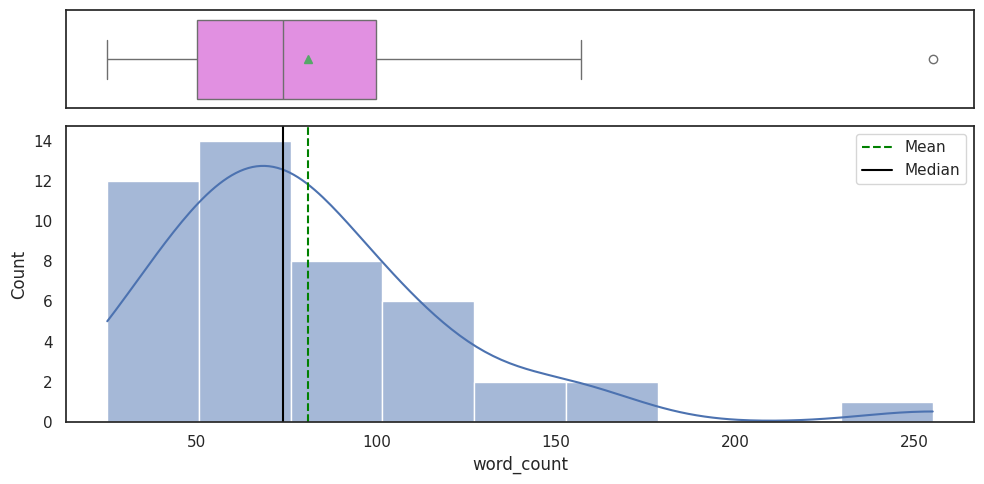

In [183]:
# Visualize the distribution of word counts for negative sentiment
print("Negative Review Word Count Distribution")
histogram_boxplot(review_df[review_df['Sentiment'] == 'neg'], 'word_count', figsize=(10, 5), kde=True)

**Explanation:**

Examining the single longest post, confirming its content and label, the row was dropped to avoid letting one outlier have a disproportionate influence on model training.

**Observation:**

The longest post is 474 words and is labeled as a truthful negative review. Removing it provides a clearer view of the remaining review patterns, particularly in the tail of the word count distribution. The updated negative sentiment histogram now shows more stable dispersion, with a median near 70 and fewer extreme values pulling the mean.


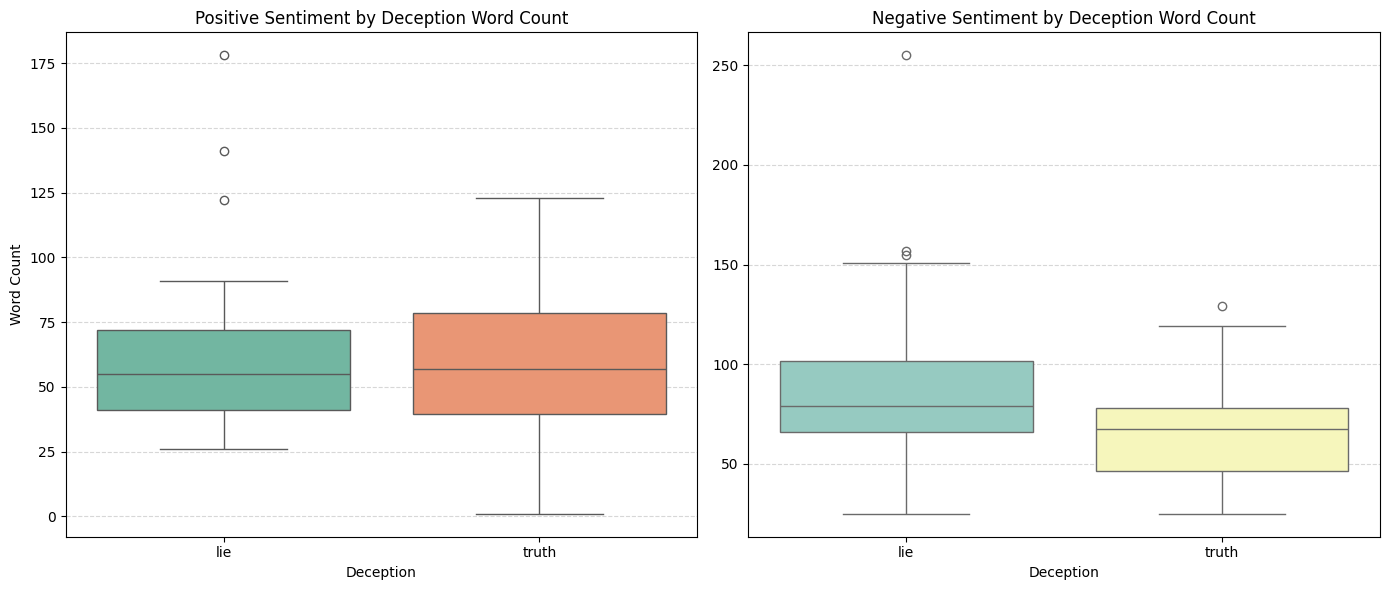

In [18]:
# Comparing positive and negative sentiment by deception
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Positive sentiment
sns.boxplot(data=review_df[review_df['Sentiment'] == 'pos'], x='Deception', y='word_count', palette='Set2', ax=axes[0])
axes[0].set_title('Positive Sentiment by Deception Word Count')
axes[0].set_xlabel('Deception')
axes[0].set_ylabel('Word Count')
axes[0].yaxis.grid(True, linestyle='--', alpha=0.5)

# Negative Sentiment
sns.boxplot(data=review_df[review_df['Sentiment'] == 'neg'], x='Deception', y='word_count', palette='Set3', ax=axes[1])
axes[1].set_title('Negative Sentiment by Deception Word Count')
axes[1].set_xlabel('Deception')
axes[1].set_ylabel('')
axes[1].yaxis.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Observation:**

Across both sentiment categories, deceptive reviews tend to show higher variance in word count, with outliers more common among negative lies. Truthful reviews remain more tightly clustered, suggesting that deceptive writing, particularly when negative, often includes added elaboration or justification.



In [184]:
# Compute sentiment propotions by actual reviews
raw_review_df = raw_vader_labels(review_df, text_col='review')
raw_review_df.head()

,review,Deception,Sentiment,word_count,vader_score,vader_sentiment
0,"'Mike\'s Pizza High Point, NY Service was very...",lie,neg,44,0.5106,pos
1,'i really like this buffet restaurant in Marsh...,lie,neg,61,0.9391,pos
2,"'After I went shopping with some of my friend,...",lie,neg,25,0.4939,pos
3,'Olive Oil Garden was very disappointing. I ex...,lie,neg,44,0.1756,pos
4,'The Seven Heaven restaurant was never known f...,lie,neg,69,-0.7000,neg


In [185]:
# Compare VADER sentiment vs actual sentiment label
comparison = (raw_review_df['vader_sentiment'] == raw_review_df['Sentiment'])
agreement_rate = comparison.mean()

print(f"VADER in agreement with Sentiment Label: {agreement_rate:.2%}")

VADER in agreement with Sentiment Label: 75.82%


**Explanation:**

A comparison of how a rule based model like VADER interprets sentiment compared to dataset's provided labels, sentiment scores were computed directly from the raw review text. Providing a baseline understanding of VADER's interpretive tendencies on the reviews before introducing machine learning.

**Observation:**

Several reviews labeled as negative by the dataset are classified as positive by VADER. This pattern is consistent with known behavior VADER which often overweights positive terms unless negation or contextual cues are present. There is a 75.8% agreement by VADER on the sentiment labels.

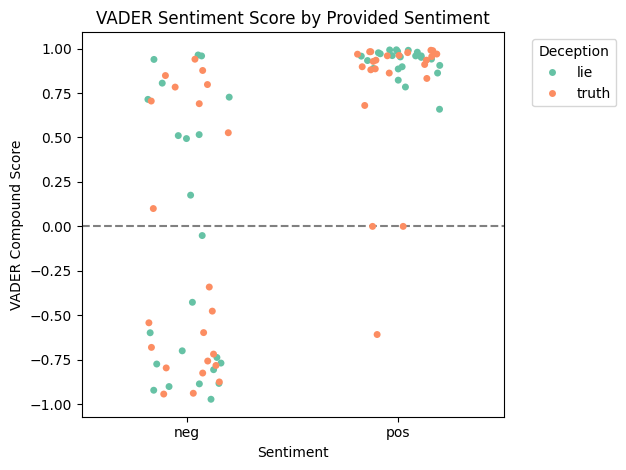

In [21]:
# VADER sentiment distribution by sentiment and deception labels
sns.stripplot(data=raw_review_df, x='Sentiment', y='vader_score', hue='Deception', jitter=0.2, palette='Set2')
plt.title("VADER Sentiment Score by Provided Sentiment")
plt.ylabel("VADER Compound Score")
plt.axhline(0, color='gray', linestyle='--')
plt.legend(title='Deception', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Observation:**

The plot shows a clear separation of VADER scores by sentiment label. Most positive labeled reviews cluster at higher scores. Several negative labeled reviews also receive high scores, specifically lies, reinforcing earlier signs that surface tone may override deeper sentiment. There is minimal overlap near zero, suggesting few ambiguous cases. The range within the negative class highlights the tendency to misclassify when context or sarcasm is present.



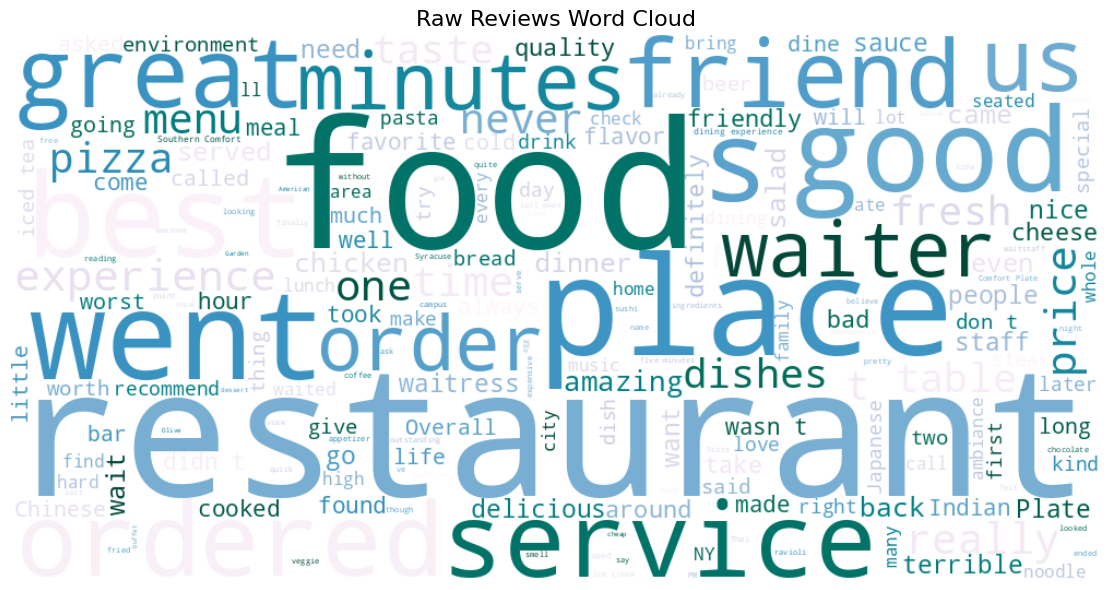

In [22]:
# Full review word cloud
overall_wordcloud(review_df, text_col='review', title='Raw Reviews Word Cloud')

**Observation:**

The word cloud shows that reviews center on core dining elements like food, restaurant, service, and place, with notable emphasis on positive descriptors such as great, good, and friend. A tendency for even critical reviews to retain neutral or positive vocabulary, considering the balanced nature of the dataset.

In [186]:
# Apply the text cleaning function to create the 'Tokens' column
review_df['Tokens'] = review_df['review'].apply(preprocess_text)

# Join tokens into a clean string
review_df['clean_text'] = review_df['Tokens'].apply(lambda tokens: ' '.join(tokens))

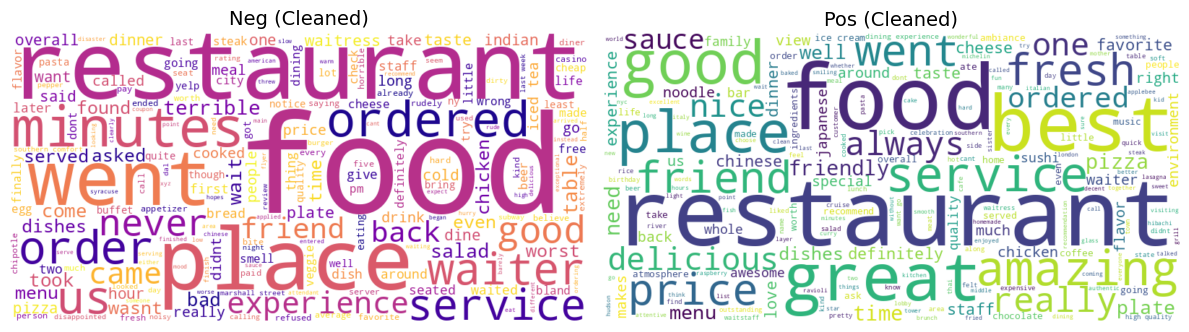

In [24]:
# Sentiment word cloud by negative and positive
group_wordclouds(review_df, text_col='clean_text', group_col='Sentiment', title_suffix='(Cleaned)')

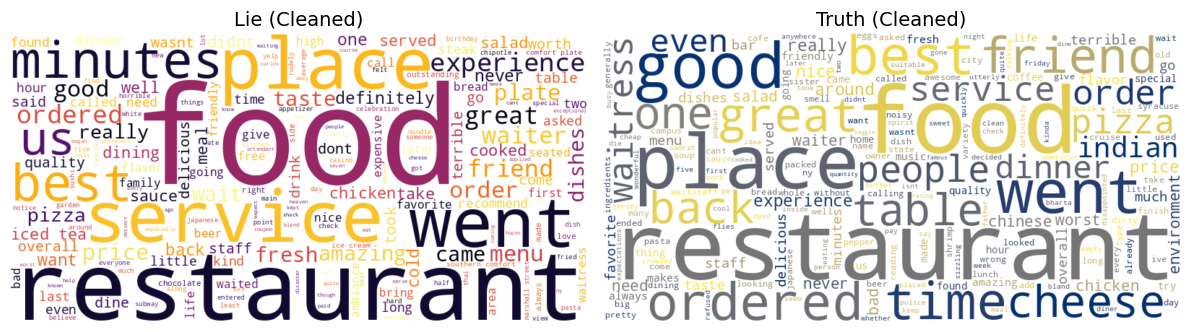

In [25]:
# Deception word cloud by lie and truth
group_wordclouds(review_df, text_col='clean_text', group_col='Deception', title_suffix='(Cleaned)')

**Observation:**

The clean text sentiment and deception word clouds reveal subtle distinctions. Positive reviews include stronger affective terms like great, amazing, and delicious, while negative ones have words like never, waiter, and experience, which hint at dissatisfaction. Comparing lies and truths, both share food centric vocabulary, but deceptive reviews also emphasize time and descriptors like best, which could be used in phrases like 'not the best.' In contrast, true reviews contain more grounded or situational terms such as cheese, people, and time.

###**Text Preprocessing, Vectorizing, and Document-Term Matrix**

In [187]:
# Base English and custom stopwords
my_stop_words = stopwords.words('english')
my_stop_words += ['restaurant', 'food', 'place', 'went', 'menu', 'ordered', 'order', 'eat',
                  'get', 'got', 'make', 'go', 'let', 'know', 'dinner', 'us', 'salad', 'sauce', 'cheese']

# Vectorize reviews using the custom stopword list
vectorizer = CountVectorizer(stop_words=my_stop_words, max_features=50, ngram_range=(1, 1), lowercase=True)

X = vectorizer.fit_transform(review_df['clean_text'])
dtm_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
dtm_df.index = review_df.index

dtm_df.head()

,also,always,amazing,around,back,bad,best,came,chicken,definitely,...,terrible,time,took,wait,waiter,waitress,want,wasnt,well,would
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1,3,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,1


In [188]:
# Attach Sentiment to the front of the DTM
df_vector_sent = pd.concat([review_df['Sentiment'], dtm_df], axis=1)

**Explanation:**

Document term matrix (DTM) using CountVectorizer, with the goal of isolating meaningful language from the corpus and removing a custom stop word list built on top of the NLTK's English stopwords. Including domain specific words like restaurant, food, place, and others common in the dataset but not informative for modeling. By setting max_features=50, the output is limited to the most prominent unigrams, ensuring focus on dominant language patterns. This vectorization is applied to the cleaned text for consistency with earlier preprocessing steps. The resulting DTM is then combined with the sentiment labels to support future classification tasks.



###**Test Train Split**

In [204]:
# Split by sentiment class
neg_df = df_vector_sent[df_vector_sent['Sentiment'] == 'neg']
pos_df = df_vector_sent[df_vector_sent['Sentiment'] == 'pos']

TrainNegDF, TestNegDF = train_test_split(neg_df, test_size=0.3, random_state=42)
TrainPosDF, TestPosDF = train_test_split(pos_df, test_size=0.3, random_state=42)

# Combine train and test sets
TrainDF = pd.concat([TrainNegDF, TrainPosDF])
TestDF = pd.concat([TestNegDF, TestPosDF])

# Separate labels and features
TrainLabels = TrainDF['Sentiment']
TestLabels = TestDF['Sentiment']

TrainX = TrainDF.drop(columns='Sentiment')
TestX = TestDF.drop(columns='Sentiment')

**Explanation:**

To keep class balance in the classification task, the dataset is first split by sentiment label into separate positive and negative. Each subset is then divided into training and test using a 70/30 split. This approach ensures that both sentiment classes are proportionally represented in each split. The training and test sets are then recombined, and the labels are separated from the features to prepare the data for model training and evaluation.

###**Sentiment: Naive Bayes with Count Vectorization**

Confusion Matrix:
[[11  3]
 [ 1 13]]

Classification Report:
              precision    recall  f1-score   support

         neg       0.92      0.79      0.85        14
         pos       0.81      0.93      0.87        14

    accuracy                           0.86        28
   macro avg       0.86      0.86      0.86        28
weighted avg       0.86      0.86      0.86        28

Accuracy: 0.86


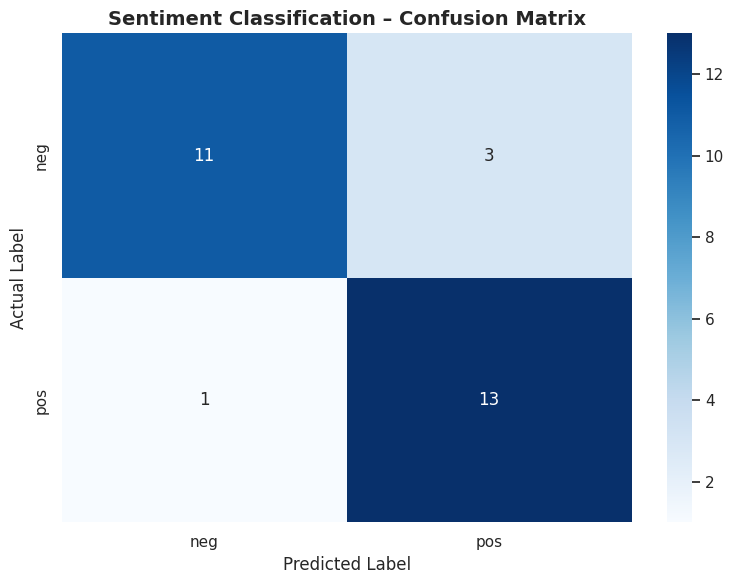

In [205]:
# Initialize model
nb_sent_model= MultinomialNB(alpha=2)

# Fit the model
nb_sent_model.fit(TrainX, TrainLabels)

# Predict on test
Prediction = nb_sent_model.predict(TestX)

print("Confusion Matrix:")
print(confusion_matrix(TestLabels, Prediction))
print("\nClassification Report:")
print(classification_report(TestLabels, Prediction))

# Evaluate
evaluate_model(nb_sent_model, TestX, TestLabels, Prediction, title='Sentiment Classification – Confusion Matrix')

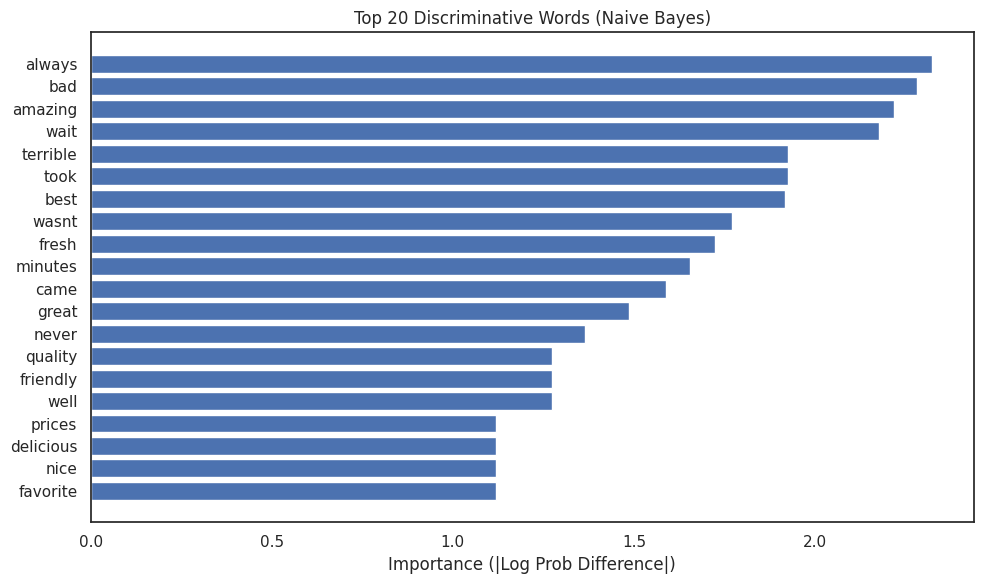

In [203]:
top_features = feature_importance(nb_sent_model, vectorizer, top_n=20)

**Explanation:**

To establish a baseline for supervised sentiment classification, a Multinomial Naive Bayes model was trained on a vectorized document term matrix using TF counts, with a tuned smoothing parameter of 3. This model assumes that words are conditionally independent based on word frequency distributions. Particularly suited for high dimensional sparse data such as bag of words text representations.


**Observation:**


The model achieved an accuracy of 86%, with tuned alpha, with balanced performance across both sentiment classes. All positive reviews were correctly classified, three negative reviews were misclassified as positive. This asymmetry is reflected in the slightly lower recall for the negative class. The most discriminative words include strong affective indicators like best, amazing, and terrible, supporting that the model successfully leveraged high sentiment signal terms. Terms like minutes and wait suggest that timing related frustration also play a role in sentiment differentiation.

###**Sentiment: Naive Bates with TF-IDF Vectorization**

Confusion Matrix (TF-IDF):
[[13  1]
 [ 2 12]]

Classification Report (TF-IDF):
              precision    recall  f1-score   support

         neg       0.87      0.93      0.90        14
         pos       0.92      0.86      0.89        14

    accuracy                           0.89        28
   macro avg       0.89      0.89      0.89        28
weighted avg       0.89      0.89      0.89        28

Accuracy: 0.89


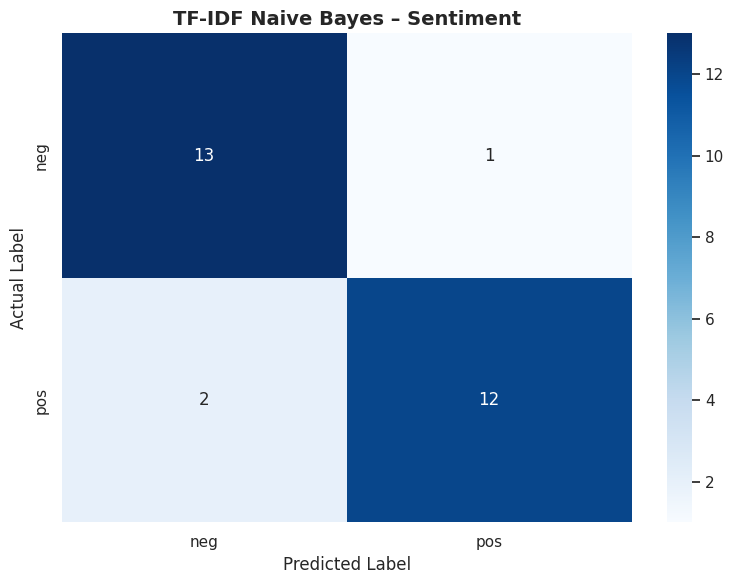

In [217]:
# Recreate splits from the original review_df
TrainDF, TestDF = train_test_split(review_df, test_size=0.3, stratify=review_df['Sentiment'], random_state=42)

tfidf_vectorizer = TfidfVectorizer(stop_words=my_stop_words, max_features=1000, ngram_range=(1, 2), lowercase=True)

# Fit on Train only, transform both
TrainX_tfidf = tfidf_vectorizer.fit_transform(TrainDF['clean_text'])
TestX_tfidf = tfidf_vectorizer.transform(TestDF['clean_text'])

TrainLabels = TrainDF['Sentiment']
TestLabels = TestDF['Sentiment']

# Initialize and train model
nb_sent_tfidf_model = MultinomialNB(alpha=.1)
nb_sent_tfidf_model.fit(TrainX_tfidf, TrainLabels)

# Predict on test data
tfidf_pred = nb_sent_tfidf_model.predict(TestX_tfidf)

# Evaluation
print("Confusion Matrix (TF-IDF):")
print(confusion_matrix(TestLabels, tfidf_pred))
print("\nClassification Report (TF-IDF):")
print(classification_report(TestLabels, tfidf_pred))

# Confusion matrix
evaluate_model(nb_sent_tfidf_model, TestX_tfidf, TestLabels, tfidf_pred, title='TF-IDF Naive Bayes – Sentiment')

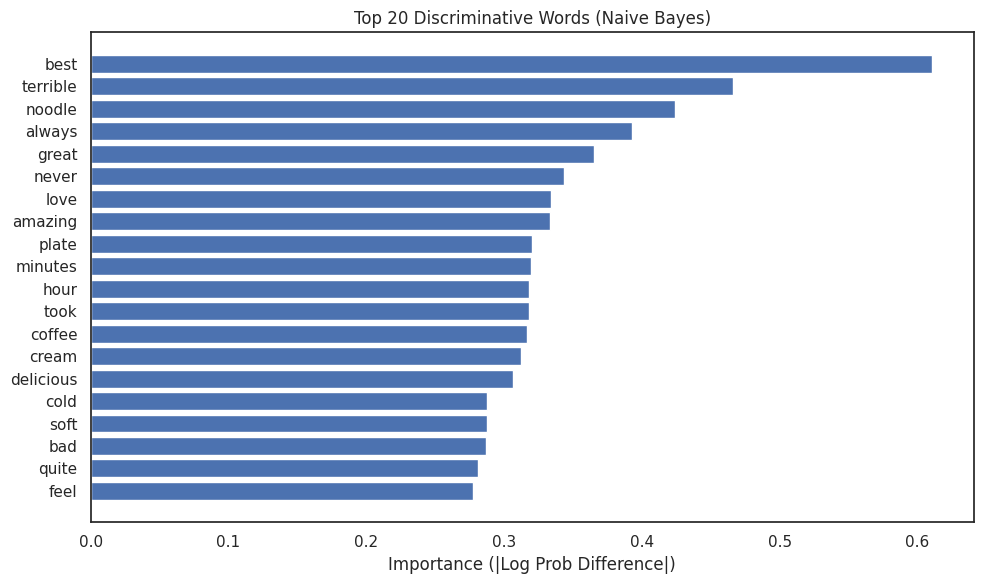

In [177]:
# Visualize the top 20 most discriminative words for sentiment (TF-IDF)
top_tfidf_features = feature_importance(nb_sent_tfidf_model, tfidf_vectorizer, top_n=20)

**Explanation:**

Multinomial Naive Bayes with TF-IDF vectorization adjusts raw term frequencies by weighting them according to how common or rare they are across the entire corpus. This helps highlight terms that are more informative for classification. The vectorizer was configured to include both unigrams and bigrams, allowing the model to capture not only individual words but also short phrases. To avoid data leakage, the labeled dataset was split first, and the TF-IDF transformation was applied only after fitting on the training set.

**Observation:**


The TF-IDF model yielded an overall accuracy of 89%, matching the count-based baseline but with a more balanced distribution across metrics. Negative sentiment recall improved to 0.93, while positive sentiment recall dropped slightly to 0.86, reflecting a tradeoff in sensitivity. The top discriminative words shifted to include more context-specific terms like noodle, plate, and cream, highlighting TF-IDF’s ability to surface distinctive vocabulary rather than general emotional tone. This shift indicates that TF-IDF better captures content-based signals that differentiate sentiment, offering a more theoretically robust feature representation for nuanced review classification.

###**Deception: Naive Bayes with Count Vectorization**


Confusion Matrix (TF-IDF):
[[8 6]
 [6 8]]

Classification Report (TF-IDF):
              precision    recall  f1-score   support

         lie       0.57      0.57      0.57        14
       truth       0.57      0.57      0.57        14

    accuracy                           0.57        28
   macro avg       0.57      0.57      0.57        28
weighted avg       0.57      0.57      0.57        28

Accuracy: 0.57


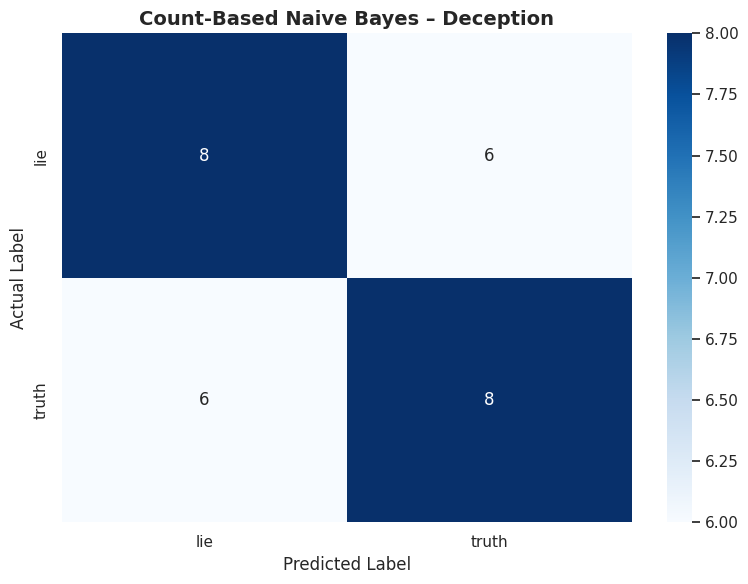

In [211]:
# Re-vectorize the full dataset
X_decept = vectorizer.fit_transform(review_df['clean_text'])
dtm_df_decept = pd.DataFrame(X_decept.toarray(), columns=vectorizer.get_feature_names_out())
dtm_df_decept.index = review_df.index

# Merge with Deception label
df_vector_decept = pd.concat([review_df['Deception'], dtm_df_decept], axis=1)

# Stratified split by deception class
truth_df = df_vector_decept[df_vector_decept['Deception'] == 'truth']
lie_df = df_vector_decept[df_vector_decept['Deception'] == 'lie']

TrainTruthDF, TestTruthDF = train_test_split(truth_df, test_size=0.3, random_state=42)
TrainLieDF, TestLieDF = train_test_split(lie_df, test_size=0.3, random_state=42)

TrainDF = pd.concat([TrainTruthDF, TrainLieDF])
TestDF = pd.concat([TestTruthDF, TestLieDF])

TrainLabels = TrainDF['Deception']
TestLabels = TestDF['Deception']
TrainX = TrainDF.drop(columns='Deception')
TestX = TestDF.drop(columns='Deception')

# Train and evaluate
nb_decep_model = MultinomialNB(alpha=3.0)
nb_decep_model.fit(TrainX, TrainLabels)
DeceptPred_Count = nb_decep_model.predict(TestX)

# Evaluation
print("Confusion Matrix (TF-IDF):")
print(confusion_matrix(TestLabels, DeceptPred_Count))
print("\nClassification Report (TF-IDF):")
print(classification_report(TestLabels, DeceptPred_Count))

# Confusion Matrix
evaluate_model(nb_decep_model, TestX, TestLabels, DeceptPred_Count, title='Count-Based Naive Bayes – Deception')

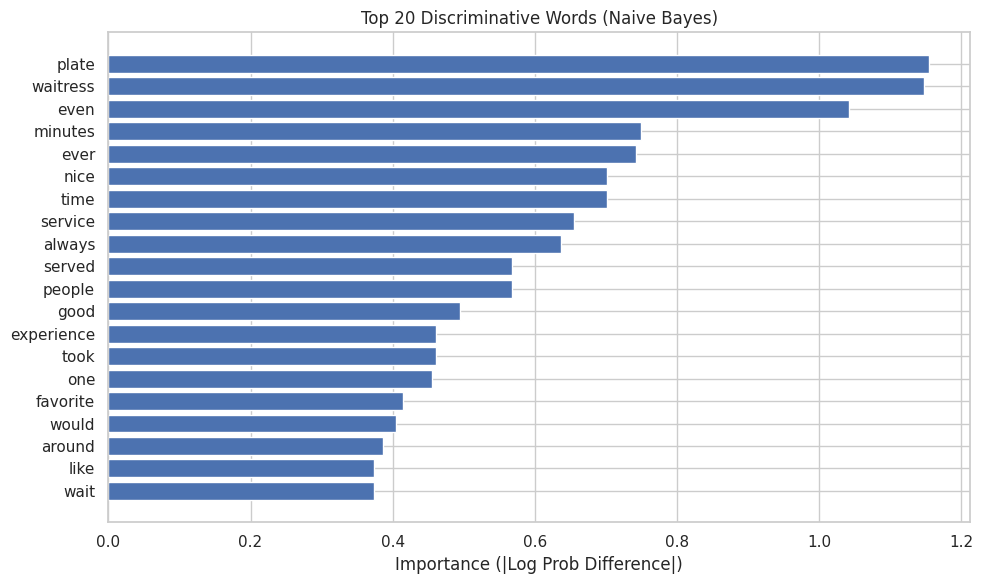

In [143]:
# Top 20 most discriminative features for deception using CountVectorizer
nb_decep_features = feature_importance(nb_decep_model, vectorizer, top_n=20)

**Observation:**

Multinomial Naive Bayes with Count vector for deception classification yielded a balanced but weak performance, with an overall accuracy of 57%. Precision, recall, and F1-score are evenly split across both deception classes indicating that the model performs no better than chance despite some separation in the confusion matrix. Both labels are misclassified at nearly equal rates, showing the classifier is struggling to learn meaningful patterns that distinguish lies from truth

The most discriminative words in the feature importance plot include highly contextual terms like plate, waitress, minutes, and service, which reflect surface level restaurant themes rather than deeper signals of deception.


Confusion Matrix (TF-IDF):
[[12  2]
 [11  3]]

Classification Report (TF-IDF):
              precision    recall  f1-score   support

         lie       0.52      0.86      0.65        14
       truth       0.60      0.21      0.32        14

    accuracy                           0.54        28
   macro avg       0.56      0.54      0.48        28
weighted avg       0.56      0.54      0.48        28

Accuracy: 0.54


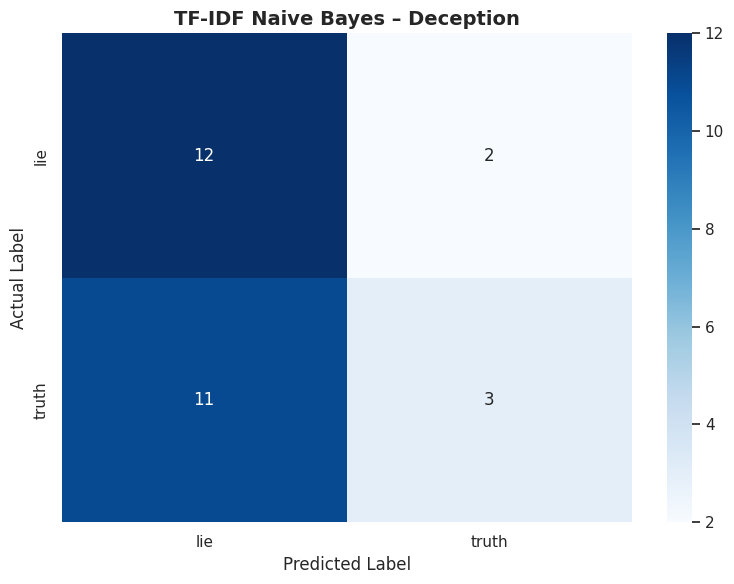

In [214]:
# Split original data again for TF-IDF based on Deception label
TrainDF, TestDF = train_test_split(review_df, test_size=0.3, stratify=review_df['Deception'], random_state=42)

TrainLabels = TrainDF['Deception']
TestLabels = TestDF['Deception']

# TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=my_stop_words,max_features=1000, ngram_range=(1, 2), lowercase=True)

TrainX_tfidf = tfidf_vectorizer.fit_transform(TrainDF['clean_text'])
TestX_tfidf = tfidf_vectorizer.transform(TestDF['clean_text'])

# Train and evaluate Naive Bayes
nb_decep_tfidf_model = MultinomialNB(alpha=5.0)
nb_decep_tfidf_model.fit(TrainX_tfidf, TrainLabels)
DeceptPred_TFIDF = nb_decep_tfidf_model.predict(TestX_tfidf)

# Evaluation
print("Confusion Matrix (TF-IDF):")
print(confusion_matrix(TestLabels, DeceptPred_TFIDF))
print("\nClassification Report (TF-IDF):")
print(classification_report(TestLabels, DeceptPred_TFIDF))

evaluate_model(nb_decep_tfidf_model, TestX_tfidf, TestLabels, DeceptPred_TFIDF, title='TF-IDF Naive Bayes – Deception')

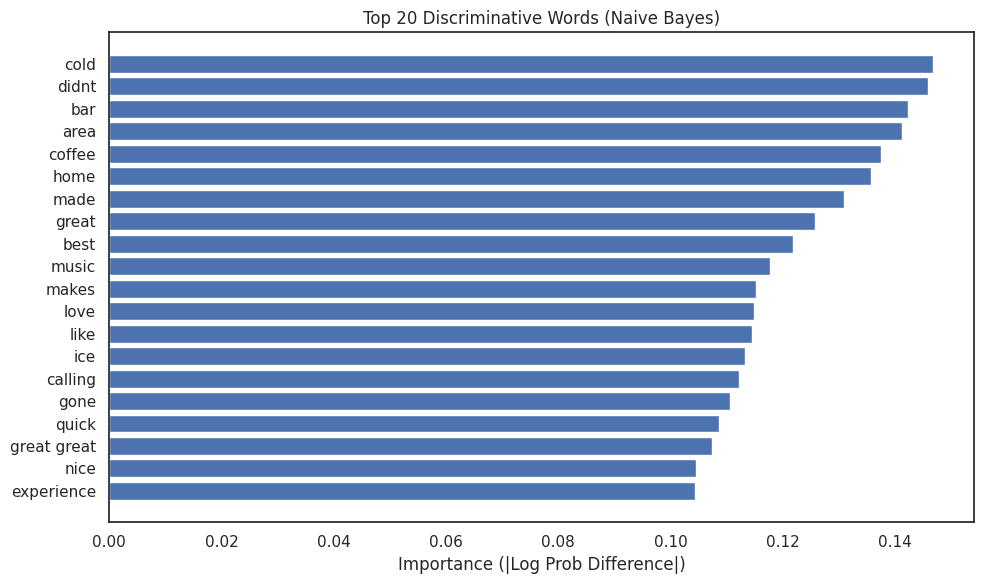

In [213]:
# Top 20 most discriminative features for deception using TF-IDF
nb_decep_tfidf_features = feature_importance(nb_decep_tfidf_model, tfidf_vectorizer, top_n=20)

**Observation:**

The TF-IDF Naive Bayes model for deception had suboptimal performance, with an overall accuracy of 0.54.  The model strongly favored detecting deceptive reviews, while it struggled to identify truthful ones. This skew is evident in the confusion matrix, where 11 of 14 truthful reviews were misclassified as lies. The discriminative word plot shows weak signals none of the terms like cold, home, or great stand out with strong association to either class. TF-IDF weighting diluted meaningful term frequency signals needed to differentiate subtle deception patterns in the dataset.

###**Cross Validation 10 Fold**

Sentiment--Count CV Accuracy: 0.75
Sentiment--TF-IDF CV Accuracy: 0.78
Deception--Count CV Accuracy: 0.46
Deception--TF-IDF CV Accuracy: 0.57


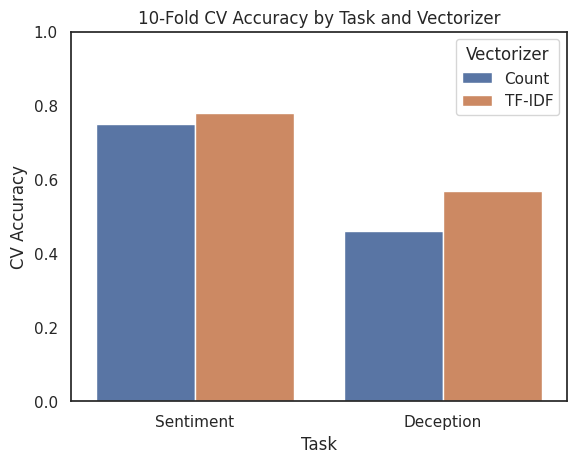

In [218]:
# Sentiment Count Vectorization
sent_X = dtm_df
sent_y = review_df['Sentiment']
cv_sent_count = cross_val_score(MultinomialNB(alpha=2.0), sent_X, sent_y, cv=10, scoring='accuracy')

# Sentiment TF-IDF Vectorization
tfidf_sent_X = tfidf_vectorizer.fit_transform(review_df['clean_text'])
cv_sent_tfidf = cross_val_score(MultinomialNB(alpha=0.1), tfidf_sent_X, sent_y, cv=10, scoring='accuracy')

# Deception Count Vectorization
decept_X = dtm_df
decept_y = review_df['Deception']
cv_decept_count = cross_val_score(MultinomialNB(alpha=3.0), decept_X, decept_y, cv=10, scoring='accuracy')

# Deception TF-IDF Vectorization
tfidf_decept_X = tfidf_vectorizer.fit_transform(review_df['clean_text'])
cv_decept_tfidf = cross_val_score(MultinomialNB(alpha=5.0), tfidf_decept_X, decept_y, cv=10, scoring='accuracy')

print("Sentiment--Count CV Accuracy:", round(cv_sent_count.mean(), 2))
print("Sentiment--TF-IDF CV Accuracy:", round(cv_sent_tfidf.mean(), 2))
print("Deception--Count CV Accuracy:", round(cv_decept_count.mean(), 2))
print("Deception--TF-IDF CV Accuracy:", round(cv_decept_tfidf.mean(), 2))

summary_df = pd.DataFrame({
    'Task': ['Sentiment', 'Sentiment', 'Deception', 'Deception'],
    'Vectorizer': ['Count', 'TF-IDF', 'Count', 'TF-IDF'],
    'CV Accuracy': [round(cv_sent_count.mean(), 2),
                    round(cv_sent_tfidf.mean(), 2),
                    round(cv_decept_count.mean(), 2),
                    round(cv_decept_tfidf.mean(), 2)]
})
sns.barplot(data=summary_df, x='Task', y='CV Accuracy', hue='Vectorizer')
plt.title("10-Fold CV Accuracy by Task and Vectorizer")
plt.ylim(0, 1)
plt.show()

**Observation:**

Both vectorizers perform well for sentiment classification, with TF-IDF achieving the highest accuracy at 0.78 and Count close behind at 0.75. This suggests that emotional language tends to be more clearly differentiated by term frequency and document rarity, making both vectorization strategies effective.

Deception detection shows weaker results overall. The CountVectorizer model reaches only 0.46 accuracy, while TF-IDF improves it slightly to 0.57. This reinforces that deception is harder to detect using simple frequency based features, the slight improvement with TF-IDF indicates that rare or context specific words may offer some additional signal, but the overall challenge remains.

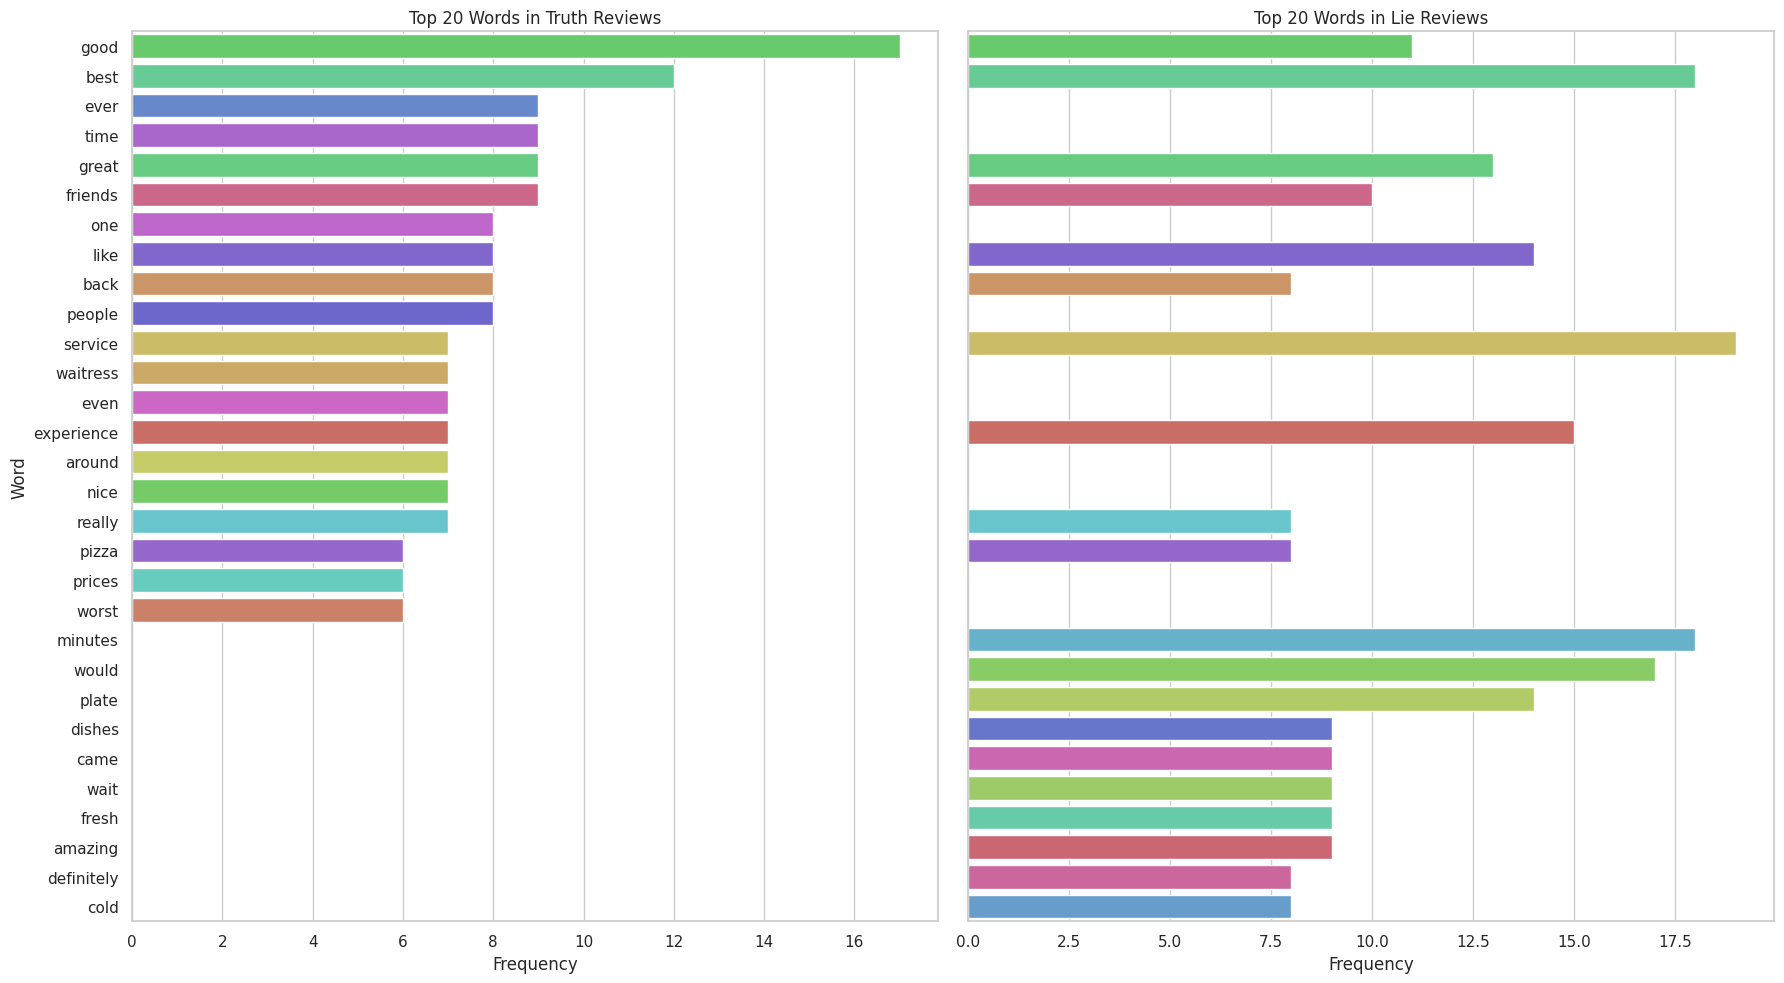

In [110]:
# Top 20 words comparison by deception
compare_top_words_by_label(df=review_df, token_col='Tokens', label_col='Deception', label1='truth',
                           label2='lie', stopword_list=my_stop_words, top_n=20)

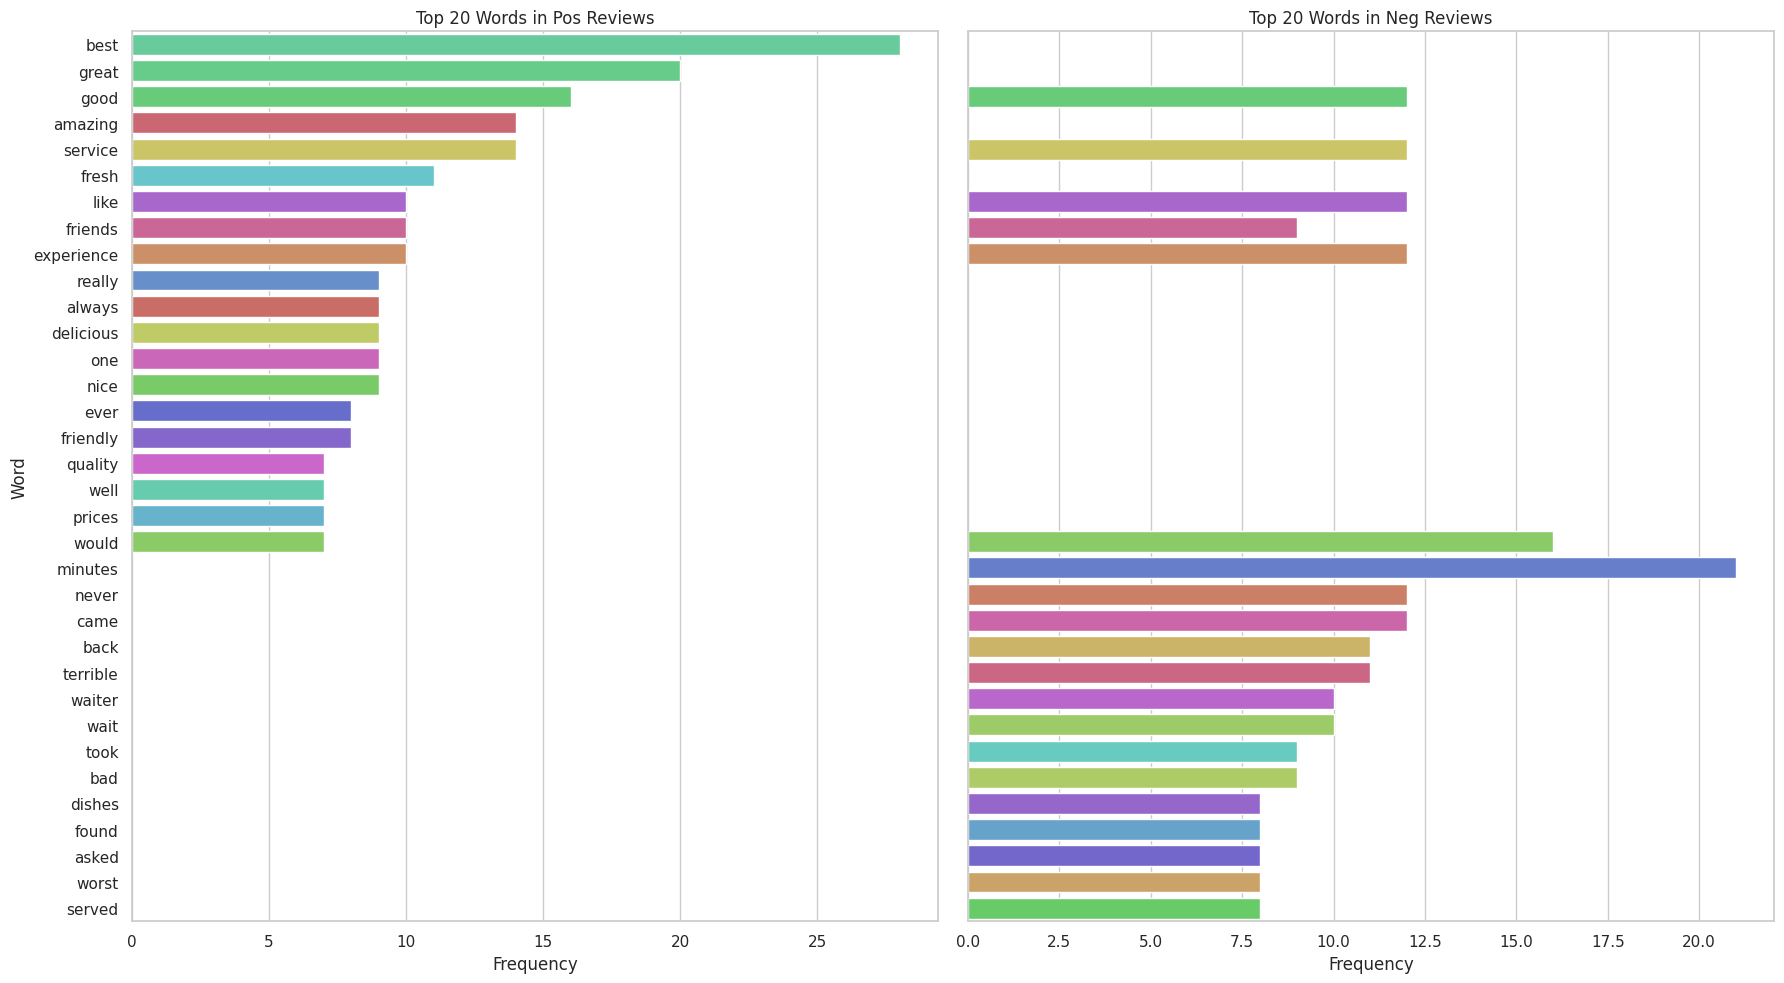

In [108]:
# Top 20 words comparison by sentiment
compare_top_words_by_label(df=review_df, token_col='Tokens', label_col='Sentiment', label1='pos',
                           label2='neg', stopword_list=my_stop_words, top_n=20)

**Observation:**

The model's difficulty in distinguishing between truth and lie reviews is reflected in the significant overlap between the two classes. Words like great, experience, nice, and pizza appear frequently in both truthful and deceptive reviews, suggesting that surface level language alone may not provide strong signals for deception detection. This overlap limits the models ability to draw clear decision boundaries, especially compared to sentiment classification, where word distributions are more polarized. In sentiment analysis, positive and negative reviews display distinct vocabularies, amazing, delicious, and friendly dominate positive reviews, while wait, never, and bad appear almost exclusively in negative ones, making it easier for the model to separate the classes based on word usage alone.

## **Conclusion**

The Naive Bayes models performed well on sentiment classification but struggled with deception. Sentiment was easier to predict because the language used in positive and negative reviews was often very different. Words like, delicious and terrible gave the model clear signals, and TF-IDF weighting helped emphasize the most important terms while reducing the impact of common ones. This made it easier for the classifier to separate the two classes and reach relatively high accuracy.

Deception was much harder to detect. The vocabulary in truthful and deceptive reviews was almost the same, which gave the model very little to work with. Even with different vectorization methods and smoothing values, the performance stayed low. The top words for each deception class were often shared or ambiguous, and the model had a tendency to predict truth more often, likely because there weren't strong cues to suggest otherwise.

These results show that surface level features like word counts work well for sentiment, where the language tends to be more polarized. But for deception, which relies more on subtlety and context, simple models like Naive Bayes have limitations. More advanced approaches that look beyond individual words may be needed to capture the patterns involved in deception.